In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Mitsubishi.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop(df2[(df2["Fiyat"] > 1000000)].index, axis=0, inplace=True)

In [4]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [5]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Attrage,Seri_Carisma,Seri_Colt,...,Model_1.8 GDI LX,Model_1.8 GLS,Model_2.0 GLS,Model_X,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,319500,2012,95,1332,168000,NaN,NaN,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,195000,1999,101,1601,275000,NaN,NaN,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,158000,2000,90,1597,243000,NaN,NaN,0,1,0,...,0,0,0,0,0,0,1,1,0,0
3,175000,1999,90,1597,348000,NaN,NaN,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,335000,2006,98,1584,206300,1.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [6]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [8]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [9]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [10]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_11736\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,47037.70692,1.118669e+09,33446.511169,27531.899075


In [11]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:18:01,463] A new study created in memory with name: no-name-9bd1d300-d333-48bc-83c7-2c579bf24031
[I 2023-10-08 14:18:01,578] Trial 0 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.12743176883858168, 'max_depth': 4, 'min_child_weight': 108}. Best is trial 0 with value: 313463.83915761905.
[I 2023-10-08 14:18:01,607] Trial 2 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.0002443226303335001, 'max_depth': 7, 'min_child_weight': 207}. Best is trial 0 with value: 313463.83915761905.
[I 2023-10-08 14:18:01,611] Trial 7 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.05374217995619395, 'max_depth': 4, 'min_child_weight': 100}. Best is trial 0 with value: 313463.83915761905.
[I 2023-10-08 14:18:01,611] Trial 3 finished with value: 313463.83915761905 and parameters: 

[I 2023-10-08 14:18:02,667] Trial 31 finished with value: 100854.55841003863 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.14033530674886968, 'max_depth': 7, 'min_child_weight': 24}. Best is trial 13 with value: 46194.651067502185.
[I 2023-10-08 14:18:02,705] Trial 29 finished with value: 49336.047726975776 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.23064462565040844, 'max_depth': 8, 'min_child_weight': 3}. Best is trial 13 with value: 46194.651067502185.
[I 2023-10-08 14:18:02,760] Trial 32 finished with value: 66752.31287224234 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.1813351425488403, 'max_depth': 7, 'min_child_weight': 25}. Best is trial 13 with value: 46194.651067502185.
[I 2023-10-08 14:18:02,822] Trial 33 finished with value: 78829.37007630002 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.19515302426244707, 'max_depth': 8, 'min_child_weight'

[I 2023-10-08 14:18:04,371] Trial 60 finished with value: 276663.26799619664 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.1452022920262108, 'max_depth': 12, 'min_child_weight': 67}. Best is trial 54 with value: 39439.403784151014.
[I 2023-10-08 14:18:04,389] Trial 62 finished with value: 242033.17858728347 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.14945340444369964, 'max_depth': 12, 'min_child_weight': 66}. Best is trial 54 with value: 39439.403784151014.
[I 2023-10-08 14:18:04,389] Trial 61 finished with value: 82412.31760006833 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.14583511169269553, 'max_depth': 12, 'min_child_weight': 12}. Best is trial 54 with value: 39439.403784151014.
[I 2023-10-08 14:18:04,396] Trial 63 finished with value: 145999.4692045292 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.1539560022587604, 'max_depth': 12, 'min_child_wei

[I 2023-10-08 14:18:05,949] Trial 89 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.49981055304481187, 'max_depth': 11, 'min_child_weight': 144}. Best is trial 77 with value: 38451.83339045021.
[I 2023-10-08 14:18:06,019] Trial 91 finished with value: 60601.388118429684 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.4938950133810761, 'max_depth': 3, 'min_child_weight': 40}. Best is trial 77 with value: 38451.83339045021.
[I 2023-10-08 14:18:06,142] Trial 92 finished with value: 63741.545709263635 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.40024619655986376, 'max_depth': 10, 'min_child_weight': 42}. Best is trial 77 with value: 38451.83339045021.
[I 2023-10-08 14:18:06,174] Trial 93 finished with value: 115437.62673813463 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.40033412340617025, 'max_depth': 10, 'min_child_wei

[I 2023-10-08 14:18:08,113] Trial 120 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.28068775230073506, 'max_depth': 7, 'min_child_weight': 228}. Best is trial 116 with value: 35213.08868352288.
[I 2023-10-08 14:18:08,116] Trial 121 finished with value: 45748.5975762786 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.29474688039972935, 'max_depth': 13, 'min_child_weight': 25}. Best is trial 116 with value: 35213.08868352288.
[I 2023-10-08 14:18:08,278] Trial 122 finished with value: 34581.62322410611 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2887711247675801, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 122 with value: 34581.62322410611.
[I 2023-10-08 14:18:08,292] Trial 123 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.293308618270536, 'max_depth': 8, 'min_child_wei

[I 2023-10-08 14:18:10,215] Trial 150 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.2638767987338109, 'max_depth': 6, 'min_child_weight': 263}. Best is trial 126 with value: 33232.26167826022.
[I 2023-10-08 14:18:10,267] Trial 151 finished with value: 55662.20252180557 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.3805290417198737, 'max_depth': 7, 'min_child_weight': 34}. Best is trial 126 with value: 33232.26167826022.
[I 2023-10-08 14:18:10,345] Trial 152 finished with value: 32647.435508390015 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.398249094737569, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 152 with value: 32647.435508390015.
[I 2023-10-08 14:18:10,406] Trial 153 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.40777829424796835, 'max_depth': 4, 'min_child_wei

[I 2023-10-08 14:18:12,250] Trial 180 finished with value: 45880.52799660336 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.4796726270052433, 'max_depth': 3, 'min_child_weight': 14}. Best is trial 160 with value: 30848.779633308266.
[I 2023-10-08 14:18:12,348] Trial 181 finished with value: 42420.31230736444 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.3351303902178756, 'max_depth': 3, 'min_child_weight': 11}. Best is trial 160 with value: 30848.779633308266.
[I 2023-10-08 14:18:12,390] Trial 182 finished with value: 49981.99879125374 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.48925137991921386, 'max_depth': 3, 'min_child_weight': 12}. Best is trial 160 with value: 30848.779633308266.
[I 2023-10-08 14:18:12,431] Trial 183 finished with value: 39101.59618944303 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.4921092326485772, 'max_depth': 5, 'min_child_wei

[I 2023-10-08 14:18:14,432] Trial 209 finished with value: 29746.67703486211 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.421984558625612, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 209 with value: 29746.67703486211.
[I 2023-10-08 14:18:14,552] Trial 211 finished with value: 33790.815395814716 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.41327927099179435, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 209 with value: 29746.67703486211.
[I 2023-10-08 14:18:14,663] Trial 212 finished with value: 33975.02134319015 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.4096351477628608, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 209 with value: 29746.67703486211.
[I 2023-10-08 14:18:14,756] Trial 214 finished with value: 36499.74246505566 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.4225673979281722, 'max_depth': 4, 'min_child_weight': 

[I 2023-10-08 14:18:16,862] Trial 240 finished with value: 33013.82260633152 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.48180075571446596, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 239 with value: 29666.45264626751.
[I 2023-10-08 14:18:16,944] Trial 241 finished with value: 33235.02503705197 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.37396544779439683, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 239 with value: 29666.45264626751.
[I 2023-10-08 14:18:16,960] Trial 242 finished with value: 45424.33321843862 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.37010378215704837, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 239 with value: 29666.45264626751.
[I 2023-10-08 14:18:17,032] Trial 243 finished with value: 36529.858613731776 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3673777909532803, 'max_depth': 4, 'min_child_weight

In [13]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 29666.4526
Best params:
	colsample_bytree: 0.6
	subsample: 0.8
	learning_rate: 0.45789127092807674
	max_depth: 4
	min_child_weight: 1


In [14]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 47448.20622391437, 'MSE': 1193642774.9038248, 'RMSE': 34549.13566073433, 'MAE': 27876.243463010203}


In [15]:
r2 = r2_score(y_test, y_pred)
r2

0.9104094423624141

In [16]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.848899507267952

In [17]:
marka_model = joblib.dump(final_model, "Mitsubishi.pkl")

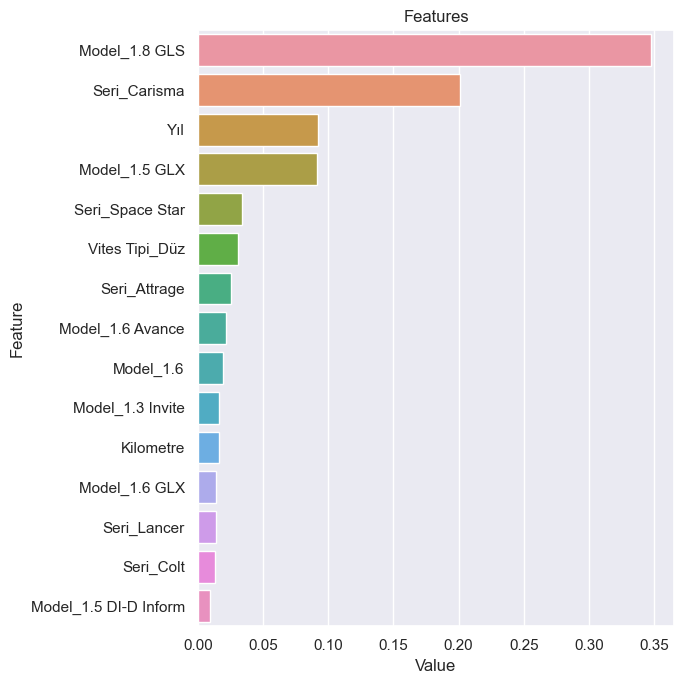

In [18]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)

In [19]:
y_test2 = list(y_test)

In [20]:
df3 = pd.DataFrame(list(zip(y_test, y_pred,(y_pred-y_test))),
               columns =['test', 'pred',"fark"])

In [21]:
df3

,test,pred,fark
0,160000,182743.859375,22743.859375
1,450000,500070.875000,50070.875000
2,155000,181848.515625,26848.515625
3,245000,285242.062500,40242.062500
4,475000,428363.875000,-46636.125000
5,245000,198709.625000,-46290.375000
6,158000,179853.296875,21853.296875
7,395000,383592.906250,-11407.093750
8,234500,163370.859375,-71129.140625
9,505000,490391.750000,-14608.250000


In [22]:
df3.describe([0.05,0.25, 0.75,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
test,49.0,291438.775510,116622.806457,85000.000000,149000.00000,210000.0000,270000.0000,355000.000,455800.00000,575000.00000,635000.00000
pred,49.0,293419.281250,116756.984375,99831.015625,156620.49375,200496.9375,272753.5625,341795.875,460352.05625,546300.64500,573117.37500
fark,49.0,1980.500478,34849.766632,-71129.140625,-58656.50625,-19556.5625,-3126.8125,26103.750,46427.95625,77860.00375,93597.34375


In [23]:
df3["test"].max()

635000

In [24]:
df3[df3["test"]==2000000]

,test,pred,fark


In [25]:
df3[df3["test"] > 500000]

,test,pred,fark
9,505000,490391.7500,-14608.2500
13,510000,517249.1875,7249.1875
41,635000,573117.3750,-61882.6250


In [26]:
y_train2 = list(y_train)

In [27]:
for i in y_train2:
    if i > 500000:
        print(i)

612000
601000
565000
657500
608000
570000
